In [0]:
# Makes plots / images embedded in the file
%matplotlib inline

In [0]:
from zipfile import ZipFile
from urllib.request import urlopen
import numpy as np

URL = 'https://uwmadison-cs534-term-project-f2018-cdh.github.io/assets/datasets/items.zip'

url = urlopen(URL)
output = open('items.zip','wb')
output.write(url.read())
output.close()

zip_ref = ZipFile('items.zip', 'r')
zip_ref.extractall('./dataset')
zip_ref.close()

In [0]:
# Import data and keras layers

from keras import backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Dense, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Dropout, BatchNormalization, Activation, SpatialDropout2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

In [98]:
import os

files = os.listdir('./dataset/items')
for name in files:
    print(name)

effects_image.npy
effects_label.npy


In [0]:
x1_raw = np.load('./dataset/items/items_image.npy')
y1_raw = np.load('./dataset/items/items_label.npy')

x1_test = np.array([])
y1_test = np.array([])

#Optimizer
adam = Adam(lr=2e-4, beta_1=0.5)

In [0]:
filterLbls = [
    #'items_tools_close-weapon',
    #'items_tools_farming-crafting',
    #'items_tools_ranged-weapon',
    #'items_tools_rod',
    #'items_tools_scepter',
    #'items_wearable_torso',
    #'items_tools_staff',
    'items_tools_shields'
  ]

y1_train = []

firstTime = True
for i in range(y1_raw.shape[0]):
  
  if y1_raw[i] in filterLbls:
    y1_train.append(y1_raw[i])
    
    if firstTime:
      firstTime = False
      raw = x1_raw[i,:,:,:]
      x1_train = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
    else:
      raw = x1_raw[i,:,:,:]
      raw = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
      x1_train = np.concatenate((x1_train,raw), axis=0)
    
y1_train = np.array(y1_train)


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  featurewise_center = True,
  featurewise_std_normalization = True,
  rotation_range = 60,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2
)

datagen.fit(x1_train)

In [102]:
#Encoder1
inputShape = (32,32,4)

encoder = Sequential()
encoder.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=inputShape)) 
encoder.add(SpatialDropout2D(0.25))
encoder.add(Conv2D(32, (3,3), strides=(2,2), activation='relu', padding='same'))
encoder.add(Conv2D(64, (3,3), strides=(2,2), activation='relu', padding='same'))

print(encoder.summary())

#Decoder1
codeShape = (8,8,64)

decoder = Sequential()
decoder.add(Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=codeShape))
decoder.add(Conv2DTranspose(16, (3,3), strides=(2,2), activation='relu', padding='same'))
decoder.add(Conv2DTranspose(4, (3,3), activation='sigmoid', padding='same'))

print(decoder.summary())

#Autoencoder1
inputImage1 = Input(shape=inputShape)
x = encoder(inputImage1)
x = decoder(x)
autoencoder = Model(inputImage1, x)
print(autoencoder.summary())
print(x1_train.shape)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 16)        592       
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 8, 64)          18496     
Total params: 23,728
Trainable params: 23,728
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_20 (Conv2DT (None, 16, 16, 32)        18464     
_________________________________________________________________
c

In [103]:
encoder.trainable = True
decoder.trainable = True
autoencoder.trainable = True

history = autoencoder.fit(x1_train, x1_train, epochs=500, batch_size=1, shuffle=True)

Epoch 1/500
384/384 [==============================] - 7s 18ms/step - loss: 0.3900
Epoch 2/500
384/384 [==============================] - 4s 11ms/step - loss: 0.2743
Epoch 3/500
384/384 [==============================] - 4s 11ms/step - loss: 0.2512
Epoch 4/500
384/384 [==============================] - 4s 11ms/step - loss: 0.2373
Epoch 5/500
384/384 [==============================] - 4s 11ms/step - loss: 0.2189
Epoch 6/500
384/384 [==============================] - 4s 11ms/step - loss: 0.2263
Epoch 7/500
384/384 [==============================] - 4s 11ms/step - loss: 0.2158
Epoch 8/500
384/384 [==============================] - 4s 11ms/step - loss: 0.2150
Epoch 9/500
384/384 [==============================] - 4s 11ms/step - loss: 0.2046
Epoch 10/500
384/384 [==============================] - 4s 11ms/step - loss: 0.2064
Epoch 11/500
384/384 [==============================] - 4s 11ms/step - loss: 0.2094
Epoch 12/500
384/384 [==============================] - 4s 11ms/step - loss: 0.1995
E

KeyboardInterrupt: ignored

(32, 32, 4)
(32, 32, 4)


(-0.5, 31.5, 31.5, -0.5)

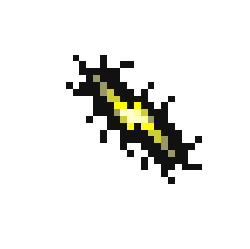

In [104]:
import random
x = random.randint(0,65)
randImg = np.reshape(x1_train[x], (1, 32, 32, 4)) 

resultImg = encoder.predict(randImg, batch_size=1)
resultImg = decoder.predict(resultImg, batch_size=1)
randImg = randImg.reshape(32,32,4)
resultImg = resultImg.reshape(32,32,4)

print(randImg.shape)
print(resultImg.shape)
from matplotlib import pyplot as plt

plt.tight_layout()
plt.imshow(randImg)
plt.axis('off')


(-0.5, 31.5, 31.5, -0.5)

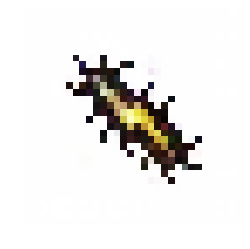

In [105]:
plt.tight_layout()
plt.imshow(resultImg)
plt.axis('off')

In [106]:
# Creating the generator
generator = Sequential()
generator.add(Dense(512*2*2, activation='relu', input_dim = 100))
generator.add(BatchNormalization())
generator.add(Reshape((2, 2, 512)))
generator.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', activation='relu'))

print(generator.summary())
generator.compile(loss = 'binary_crossentropy', optimizer = adam)  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 2048)              206848    
_________________________________________________________________
batch_normalization_17 (Batc (None, 2048)              8192      
_________________________________________________________________
reshape_9 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_23 (Conv2DT (None, 4, 4, 128)         1638528   
_________________________________________________________________
batch_normalization_18 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 8, 8, 64)          204864    
Total params: 2,058,944
Trainable params: 2,054,592
Non-trainable params: 4,352
______________________________________________________________

In [107]:
# Creating the discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = (5, 5), strides = (2, 2), padding = 'same', input_shape = (8, 8, 64)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(128, kernel_size = (5, 5), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(256, kernel_size = (5, 5), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation = 'sigmoid'))

print(discriminator.summary())
discriminator.compile(loss = 'binary_crossentropy', optimizer = adam) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 4, 4, 64)          102464    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 2, 2, 128)         204928    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1, 1, 256)         819456    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 256)               0         
__________

In [108]:
# Create the GAN
decoder.trainable = False
encoder.trainale = False
discriminator.trainable = False
gan = Sequential()
gan.add(generator)
gan.add(decoder)
gan.add(encoder)
gan.add(discriminator)

encoder.trainable = False
decoder.trainable = False
autoencoder.trainable = False

gan.compile(loss = 'binary_crossentropy', optimizer = adam)
print(gan.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_29 (Sequential)   (None, 8, 8, 64)          2058944   
_________________________________________________________________
sequential_28 (Sequential)   (None, 32, 32, 4)         23668     
_________________________________________________________________
sequential_27 (Sequential)   (None, 8, 8, 64)          23728     
_________________________________________________________________
sequential_30 (Sequential)   (None, 1)                 1127105   
Total params: 3,233,445
Trainable params: 2,054,592
Non-trainable params: 1,178,853
_________________________________________________________________
None


In [0]:
# Visualize generated data
def plotGeneratedImages():
  generated_images = decoder.predict(generator.predict(noise1))
  fig = plt.figure(figsize=(9, 9))        
  for i in range(9 if generated_images.shape[0] > 9 else generated_images.shape[0]):
    plt.subplot(3, 3, i+1)
    img = np.clip(generated_images[i, :],0,1)
    img = img.reshape((32, 32, 4))
    plt.tight_layout()
    plt.imshow(img)
    plt.axis('off')

In [0]:
# Plot losses
def plotLosses():
  fig = plt.figure(figsize=(10, 5))        
  fig.suptitle('epoch: ' + str(epoch + 1))
  plt.plot(discriminator_loss, label="discriminator's loss", color='b')
  plt.plot(gan_loss, label="generator's loss", color='r')
  plt.xlim([0, epochs * 1])
  plt.legend()

100%|██████████| 6/6 [00:00<00:00, 10.71it/s]


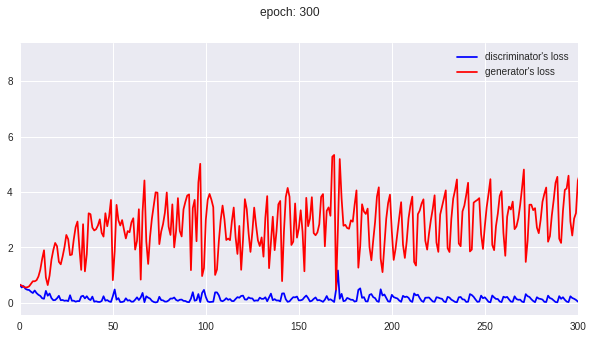

In [111]:
epochs = 300
batch_size = 16

batch_count = int(x1_train.shape[0] / batch_size)

iterator = datagen.flow(x1_train, batch_size=batch_size)
gan_loss = []
discriminator_loss = []

for epoch in range(epochs):

    for index in tqdm(range(batch_count)):
        
        # Real images
        image_batch = x1_train[index * batch_size: (index + 1) * batch_size]
        #image_batch = iterator.next()
        
        # Get initial random input for generator
        noise = np.random.uniform(-1, 1, size=[batch_size, 100])
        
        # Generating images
        generated_data = generator.predict_on_batch(noise)
        generated_data = decoder.predict_on_batch(generated_data)

        # Train discriminator
        X = np.concatenate((image_batch,generated_data))
        y = np.concatenate((np.zeros(image_batch.shape[0]),np.ones(batch_size)))
        
        X = encoder.predict_on_batch(X)
        
        discriminator.trainable = True
        disc_loss = discriminator.train_on_batch(x=X, y=y)
        
        # Train generator 
        y = np.zeros(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(x=noise, y=y)
        
        discriminator_loss.append(disc_loss)
        gan_loss.append(g_loss)
        img = generated_images = decoder.predict(generator.predict(noise))
        
plotLosses()        

In [0]:
noise1 = np.random.uniform(-1, 1, size=[9, 100])

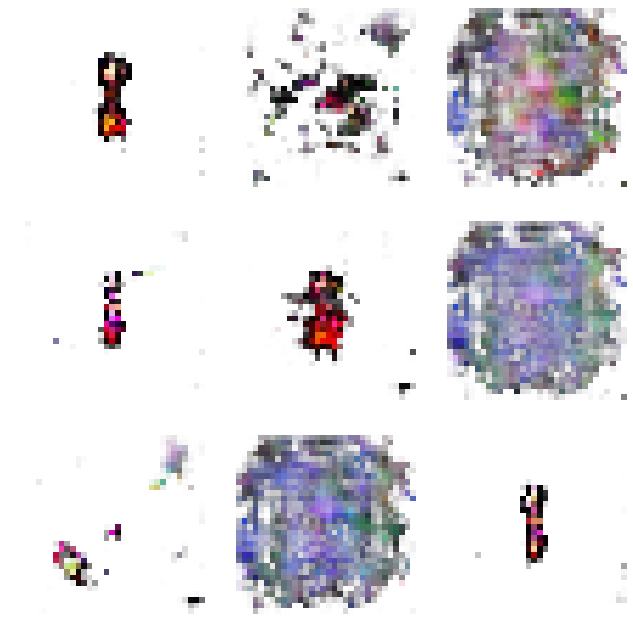

In [118]:
plotGeneratedImages()